
# Assignment 2 — Softmax Regression (Multiclass, NumPy-only)
Yêu cầu:
- **NumPy-only** để xây mô hình Softmax Regression (đa lớp: *dropout / enrolled / graduate*).
- Huấn luyện bằng **Gradient Descent** trên bộ dữ liệu UCI *Predict students’ dropout and academic success* (ID=697).
- **Đánh giá** mô hình (accuracy, macro P/R/F1, confusion matrix).
- **Trực quan hóa** hàm mất mát (loss) theo epoch.
- **Tránh mọi hình thức data leakage**: split **trước**, mọi biến đổi/loại thuộc tính/chuẩn hóa đều **fit trên train** rồi áp dụng cho test.
- **Bổ sung**: In thông tin từng biến; vẽ **ma trận tương quan** (trên **train**); loại bỏ thuộc tính có tương quan cao (|corr| ≥ 0.9) **dựa trên train**.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cấu hình
RANDOM_SEED = 42
TRAIN_RATIO = 0.8
HIGH_CORR_THRESHOLD = 0.90
LR = 0.1
EPOCHS = 500

rng = np.random.default_rng(RANDOM_SEED)

def safe_show():
    try:
        plt.show()
    except Exception as e:
        print("Plot display error:", e)


## 1) Tải dữ liệu

In [2]:

from ucimlrepo import fetch_ucirepo

ds = fetch_ucirepo(id=697)
X = ds.data.features.copy()
y = ds.data.targets.copy()

print("Loaded UCI dataset 697")
print("X shape:", X.shape, "| y shape:", y.shape)
display(X.head(3))
display(y.head(3))

target_col = 'Target' if 'Target' in y.columns else y.columns[0]
y_str = y[target_col].astype(str).str.lower().str.strip()


Loaded UCI dataset 697
X shape: (4424, 36) | y shape: (4424, 1)


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74


,Target
0,Dropout
1,Graduate
2,Dropout


## 2) Thông tin từng biến thành phần trong bộ dữ liệu

In [3]:

df_full = pd.concat([X.copy(), y_str.rename('Target')], axis=1)
for col_name in df_full.columns:
    print("Title:", col_name)
    print("Total NaN:", df_full[col_name].isna().sum())
    print("Total null:", df_full[col_name].isnull().sum())
    print("Data type:", df_full[col_name].dtype)
    print("*"*10)


Title: Marital Status
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Application mode
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Application order
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Course
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Daytime/evening attendance
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Previous qualification
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Previous qualification (grade)
Total NaN: 0
Total null: 0
Data type: float64
**********
Title: Nacionality
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Mother's qualification
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Father's qualification
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Mother's occupation
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Father's occupation
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Admission g

## 3) Tạo nhãn đa lớp & Chia train/test (stratified, trước mọi biến đổi)

In [4]:

label_map = {'dropout':0, 'enrolled':1, 'graduate':2}
def map_label(t):
    for k,v in label_map.items():
        if t.startswith(k):
            return v
    raise ValueError("Unknown label: "+t)

y_num = y_str.map(map_label).values

# Stratified split bằng NumPy
idx_all = np.arange(len(y_num))
tr_idx_list, te_idx_list = [], []
for c in np.unique(y_num):
    idx_c = idx_all[y_num == c]
    rng.shuffle(idx_c)
    split = int(TRAIN_RATIO * len(idx_c))
    tr_idx_list.append(idx_c[:split])
    te_idx_list.append(idx_c[split:])

tr_idx = np.concatenate(tr_idx_list); te_idx = np.concatenate(te_idx_list)
rng.shuffle(tr_idx); rng.shuffle(te_idx)

X_tr_df, X_te_df = X.iloc[tr_idx].copy(), X.iloc[te_idx].copy()
y_tr, y_te = y_num[tr_idx], y_num[te_idx]

print("Train size:", len(y_tr), "| Test size:", len(y_te))
print("Class dist (train):", {k:int((y_tr==k).sum()) for k in np.unique(y_tr)})
print("Class dist (test):", {k:int((y_te==k).sum()) for k in np.unique(y_te)})


Train size: 3538 | Test size: 886
Class dist (train): {0: 1136, 1: 635, 2: 1767}
Class dist (test): {0: 285, 1: 159, 2: 442}


## 4) One-hot các cột phân loại (fit **trên train**, áp dụng **cho test**)

In [5]:

cat_cols = X_tr_df.select_dtypes(exclude=[np.number]).columns.tolist()

X_tr_oh = pd.get_dummies(X_tr_df, columns=cat_cols, drop_first=True)
X_te_oh = pd.get_dummies(X_te_df, columns=cat_cols, drop_first=True)
X_te_oh = X_te_oh.reindex(columns=X_tr_oh.columns, fill_value=0)

print("After one-hot: train =", X_tr_oh.shape, "| test =", X_te_oh.shape)


After one-hot: train = (3538, 36) | test = (886, 36)


## 5) Ma trận tương quan (TRAIN) & loại thuộc tính tương quan cao (|corr| ≥ 0.90)

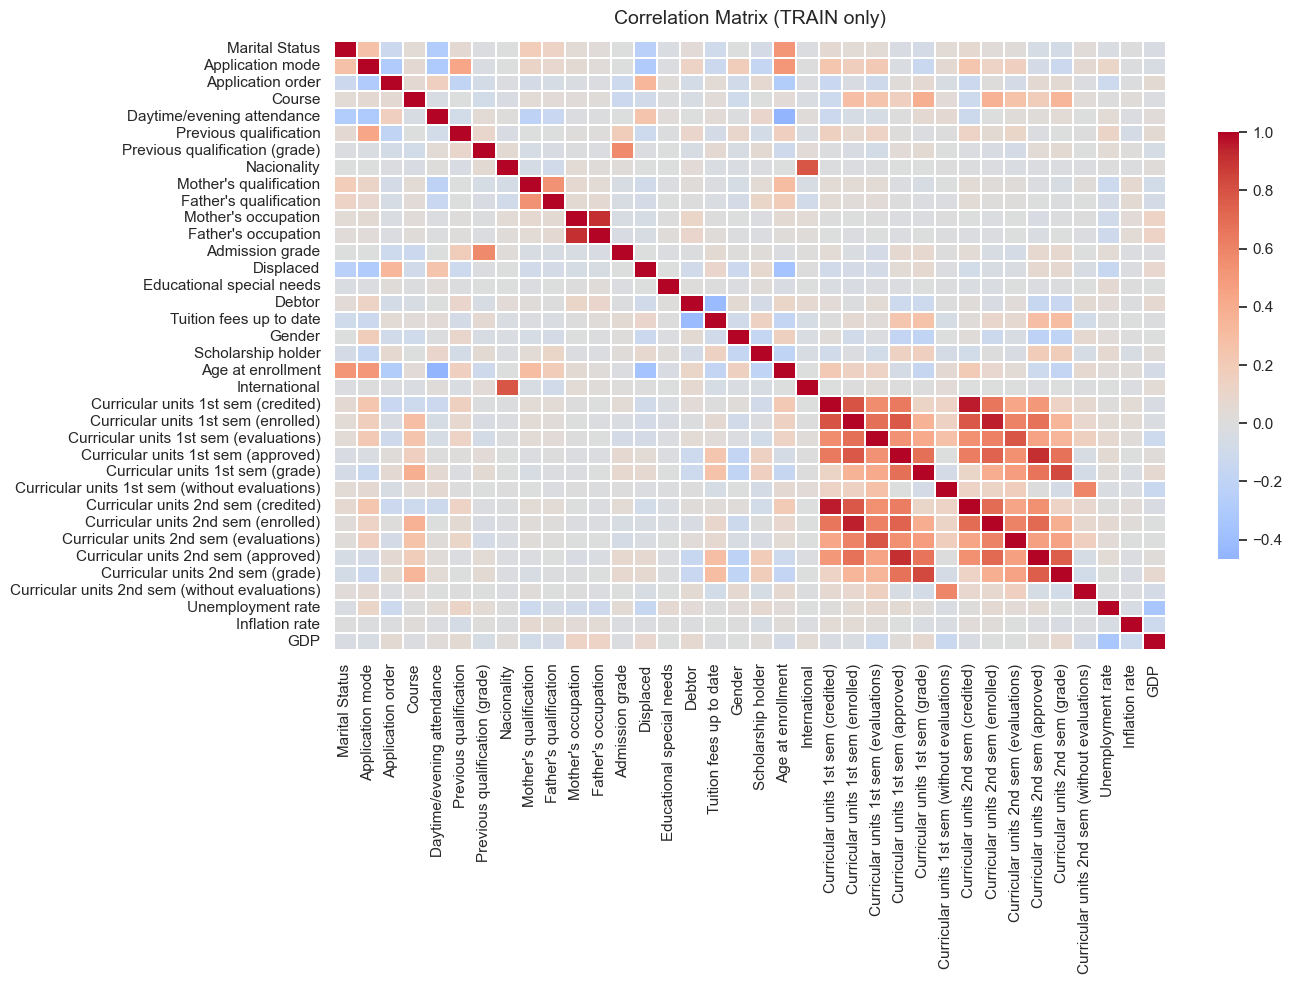

Số cột bị drop do tương quan cao: 4
Preview: ['Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', "Father's occupation"]
Shapes after drop-high-corr: train = (3538, 32) | test = (886, 32)


In [6]:

corr = X_tr_oh.corr(numeric_only=True)

plt.figure(figsize=(14,10))
sns.set_theme(style='white')
sns.heatmap(corr, cmap='coolwarm', center=0, cbar_kws={'shrink':0.7}, linewidths=0.2)
plt.title("Correlation Matrix (TRAIN only)", fontsize=14, pad=12)
plt.tight_layout()
safe_show()

# Loại theo tam giác trên: mỗi cặp chỉ drop 1 cột (cột 'bên phải')
to_drop = set()
corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

for col in upper.columns:
    partners = [row for row, val in upper[col].items() if (not pd.isna(val)) and (val >= HIGH_CORR_THRESHOLD)]
    if len(partners) > 0:
        to_drop.add(col)

to_drop = sorted(list(to_drop))
print("Số cột bị drop do tương quan cao:", len(to_drop))
print("Preview:", to_drop[:30])

X_tr_sel = X_tr_oh.drop(columns=to_drop, errors='ignore')
X_te_sel = X_te_oh.drop(columns=to_drop, errors='ignore')
print("Shapes after drop-high-corr: train =", X_tr_sel.shape, "| test =", X_te_sel.shape)


## 6) Chuẩn hoá theo thống kê **train**, rồi áp dụng cho **test** (không leak) + thêm bias

In [7]:

Xtr_np = X_tr_sel.to_numpy(dtype=float)
Xte_np = X_te_sel.to_numpy(dtype=float)

mu  = Xtr_np.mean(axis=0, keepdims=True)
std = Xtr_np.std(axis=0,  keepdims=True) + 1e-8

Xtr = (Xtr_np - mu) / std
Xte = (Xte_np - mu) / std

Xtr = np.hstack([np.ones((Xtr.shape[0],1)), Xtr])
Xte = np.hstack([np.ones((Xte.shape[0],1)), Xte])

print("Final matrices:", Xtr.shape, Xte.shape)


Final matrices: (3538, 33) (886, 33)


## 7) Huấn luyện Softmax Regression (NumPy-only, Gradient Descent)

In [8]:

K = len(np.unique(y_tr))

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    e = np.exp(z)
    return e / e.sum(axis=1, keepdims=True)

def one_hot(y, K):
    oh = np.zeros((len(y), K))
    oh[np.arange(len(y)), y] = 1.0
    return oh

def nll_loss(logits, y):
    p = softmax(logits)
    return -np.mean(np.log(p[np.arange(len(y)), y] + 1e-12))

n, d = Xtr.shape
W = np.zeros((d, K))
Ytr = one_hot(y_tr, K)

losses = []
for ep in range(EPOCHS):
    logits = Xtr @ W
    probs = softmax(logits)
    loss = nll_loss(logits, y_tr)
    losses.append(loss)
    grad = (Xtr.T @ (probs - Ytr)) / n
    W -= LR * grad
    if (ep+1) % 50 == 0:
        print(f"Epoch {ep+1}/{EPOCHS} | loss={loss:.5f}")


Epoch 50/500 | loss=0.67387
Epoch 100/500 | loss=0.64201
Epoch 150/500 | loss=0.62978
Epoch 200/500 | loss=0.62330
Epoch 250/500 | loss=0.61927
Epoch 300/500 | loss=0.61647
Epoch 350/500 | loss=0.61438
Epoch 400/500 | loss=0.61275
Epoch 450/500 | loss=0.61143
Epoch 500/500 | loss=0.61032


## 8) Đánh giá mô hình

In [9]:

def predict(W, X):
    return np.argmax(softmax(X @ W), axis=1)

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def prf_macro(y_true, y_pred, K):
    P, R, F = [], [], []
    for k in range(K):
        tp = np.sum((y_true==k) & (y_pred==k))
        fp = np.sum((y_true!=k) & (y_pred==k))
        fn = np.sum((y_true==k) & (y_pred!=k))
        prec = tp / (tp+fp+1e-12)
        rec  = tp / (tp+fn+1e-12)
        f1   = 2*prec*rec / (prec+rec+1e-12)
        P.append(prec); R.append(rec); F.append(f1)
    return np.mean(P), np.mean(R), np.mean(F)

yhat_tr = predict(W, Xtr)
yhat_te = predict(W, Xte)

Pm, Rm, Fm = prf_macro(y_te, yhat_te, K)

# Confusion matrix
cm = np.zeros((K,K), dtype=int)
for t,p in zip(y_te, yhat_te):
    cm[t,p]+=1

print("Train Acc:", accuracy(y_tr, yhat_tr))
print("Test  Acc:", accuracy(y_te, yhat_te))
print(f"Macro P/R/F1 (test): {Pm:.3f}/{Rm:.3f}/{Fm:.3f}")
print("Confusion matrix (test):\n", cm)


Train Acc: 0.7543810062182024
Test  Acc: 0.7641083521444695
Macro P/R/F1 (test): 0.704/0.661/0.668
Confusion matrix (test):
 [[222  24  39]
 [ 30  43  86]
 [ 11  19 412]]


## 9) Đồ thị hàm mất mát (Loss) theo epoch

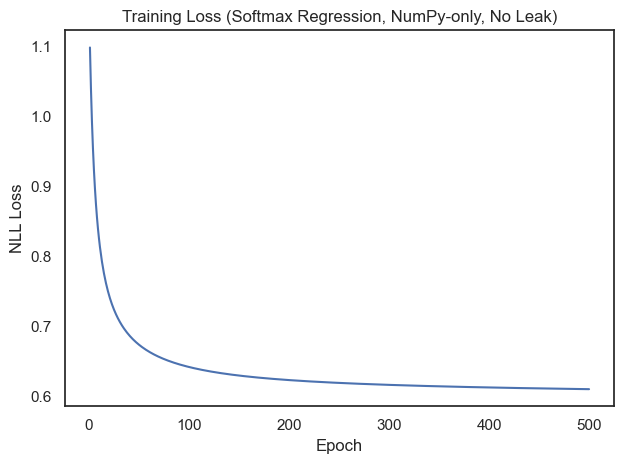

In [10]:

plt.figure()
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.title("Training Loss (Softmax Regression, NumPy-only, No Leak)")
plt.tight_layout()
safe_show()
